# Linkedin Social Network Link Analysis
A project on analyzing social networks using recommender systems techniques.

## Imports

In [180]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [181]:
df_raw = pd.read_csv("../data/Connections.csv")
df_raw

,First Name,Last Name,URL,Email Address,Company,Position,Connected On
0,Kamesh,Anuradha,https://www.linkedin.com/in/kamesh-anuradha,NaN,ISA,AI Engineer,27 Jan 2026
1,Hirushi Chameesha,de Silva,https://www.linkedin.com/in/hirushi-chameesha-...,NaN,Emojot,QA Lead,26 Jan 2026
2,Anuruddha,Liyanarachchi,https://www.linkedin.com/in/anuruddhal,NaN,WSO2,Technical Lead,26 Jan 2026
3,Ruvini,Rajapaksha,https://www.linkedin.com/in/ruvini-rajapaksha-...,NaN,Virtusa,Senior Consultant,25 Jan 2026
4,Shakya,Dissanayake,https://www.linkedin.com/in/shakyadissanayake,NaN,"Augustory, Corp. (Formerly Nerve8)",Machine Learning Engineer,24 Jan 2026
...,...,...,...,...,...,...,...
1675,Movindu,Thiumila Gunarathna,https://www.linkedin.com/in/movindugunarathna,NaN,Toyota Lanka (Private) Limited,Project Assistant,07 Oct 2021
1676,Sandhu,Divyan MBCS,https://www.linkedin.com/in/sandhu-divyan-mbcs...,NaN,Umbrella Transfers - London Airport Transfers ...,SEO & SEM Specialist,07 Oct 2021
1677,Santhusha Janana,Mudannayaka,https://www.linkedin.com/in/santhusha-mudannayaka,NaN,Berkeley SkyDeck,Software Engineer Intern,05 Oct 2021
1678,Odil,Janandith,https://www.linkedin.com/in/odil-janandith-940...,NaN,RoboticGen Academy,Chief Technology Officer,04 Oct 2021


In [182]:
df_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   First Name     1652 non-null   str  
 1   Last Name      1652 non-null   str  
 2   URL            1652 non-null   str  
 3   Email Address  30 non-null     str  
 4   Company        1427 non-null   str  
 5   Position       1427 non-null   str  
 6   Connected On   1680 non-null   str  
dtypes: str(7)
memory usage: 92.0 KB


## Data Preprocessing

### Drop NA

In [183]:
df_full = df_raw.copy()[['First Name', 'Last Name', 'Company', 'Position', 'Connected On']]
df_full = df_full.dropna().reset_index(drop=True)
print("DataFrame shape after dropping NA:", df_full.shape)
df_full.head()

DataFrame shape after dropping NA: (1427, 5)


,First Name,Last Name,Company,Position,Connected On
0,Kamesh,Anuradha,ISA,AI Engineer,27 Jan 2026
1,Hirushi Chameesha,de Silva,Emojot,QA Lead,26 Jan 2026
2,Anuruddha,Liyanarachchi,WSO2,Technical Lead,26 Jan 2026
3,Ruvini,Rajapaksha,Virtusa,Senior Consultant,25 Jan 2026
4,Shakya,Dissanayake,"Augustory, Corp. (Formerly Nerve8)",Machine Learning Engineer,24 Jan 2026


### Add full name

In [184]:
df_full['Full Name'] = df_full[["First Name", "Last Name"]].agg(' '.join, axis=1)
df_full.drop(columns=['First Name', 'Last Name'], inplace=True)
df_full.head()

,Company,Position,Connected On,Full Name
0,ISA,AI Engineer,27 Jan 2026,Kamesh Anuradha
1,Emojot,QA Lead,26 Jan 2026,Hirushi Chameesha de Silva
2,WSO2,Technical Lead,26 Jan 2026,Anuruddha Liyanarachchi
3,Virtusa,Senior Consultant,25 Jan 2026,Ruvini Rajapaksha
4,"Augustory, Corp. (Formerly Nerve8)",Machine Learning Engineer,24 Jan 2026,Shakya Dissanayake


### Sample data

In [185]:
df = df_full.groupby('Company', group_keys=False).sample(frac=0.2, random_state=42).reset_index(drop=True)
print("Sampled DataFrame shape:", df.shape)
df.head()

Sampled DataFrame shape: (141, 4)


,Company,Position,Connected On,Full Name
0,4Axis,Associate Software Quality Assurance Engineer,01 Jun 2023,Nimesh Karunaratne
1,99x,Senior Software Engineer,17 Jan 2026,Chathulanka Gamage
2,99x,Technical Lead: Agentic AI,08 Jan 2026,Poornima Kahatapitiya
3,99x,Associate Software Engineer,09 Jun 2025,Pasindu Aluthwalahewa
4,A*STAR Institute of High Performance Computing...,Research Intern,08 Nov 2021,Kumal Hewagamage


In [186]:
df['Company'].value_counts()

Company
WSO2                         26
University of Moratuwa        5
IFS                           4
99x                           3
CodeGen International         3
                             ..
WIWIS.AI                      1
Zebra Technologies            1
hSenid Business Solutions     1
iVedha Inc.                   1
icieos                        1
Name: count, Length: 92, dtype: int64

In [187]:
df = df_full.copy()

## Make Graph

### Make connection between me and others

In [188]:
G = nx.Graph()

MY_NODE = "Ravindu Weerasinghe"
NODES = df_full["Full Name"].tolist()
NODES.append(MY_NODE)
EDGES = df_full["Full Name"].apply(lambda x: (x, MY_NODE)).tolist()

### Make connection between others

In [189]:
company_edges = df_full.groupby('Company')['Full Name'].apply(lambda x: list(combinations(x, 2)) if len(x) > 1 else []).explode().dropna().tolist()
EDGES.extend(company_edges)

### Make graph

In [190]:
assert NODES is not None, "NODES list should not be None"
assert EDGES is not None, "EDGES list should not be None"
assert len(NODES) == len(df_full) + 1, "NODES list length should be equal to number of connections plus one for MY_NODE"
assert len(EDGES) >= len(df_full), "EDGES list length should be equal to or greater than number of connections"

G.add_nodes_from(NODES)
G.add_edges_from(EDGES)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 1427
Number of edges: 11965


### Subgraph visualization

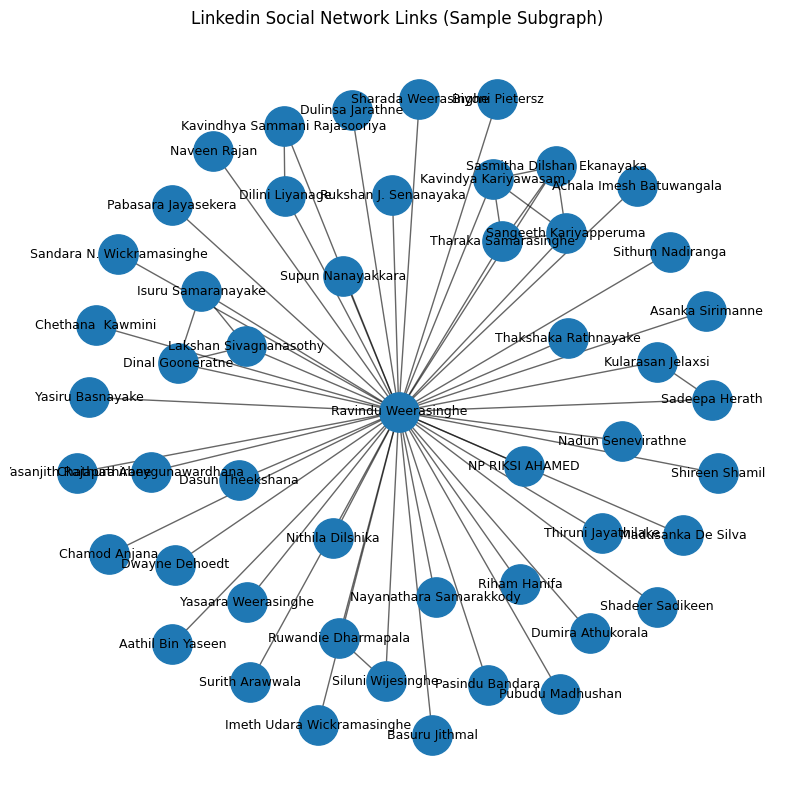

In [191]:
sample_size = 50
np.random.seed(45)  # for reproducibility
sampled_nodes = np.random.choice(NODES, size=min(sample_size, len(NODES)), replace=False)
if MY_NODE not in sampled_nodes:
    sampled_nodes[0] = MY_NODE  # Ensure MY_NODE is included

G_sample = G.subgraph(sampled_nodes)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_sample, seed=42)  # stable layout

nx.draw_networkx_nodes(G_sample, pos, node_size=800)
nx.draw_networkx_labels(G_sample, pos, font_size=9)
nx.draw_networkx_edges(G_sample, pos, arrows=False, width=1, alpha=0.6)

plt.title("Linkedin Social Network Links (Sample Subgraph)")
plt.axis("off")
plt.show()

## Helper Functions

In [192]:
def to_ranked_df(metric_dicts, col_names, top_n=None, ascending=False):
    """Convert one or more dictionaries {node: value} to a sorted DataFrame.
    
    Args:
        metric_dicts: dict or list of dicts with {node: value} structure
        col_names: str or list of str for column names
        top_n: int, limit rows to top_n
        ascending: bool, sort order
    """
    # Single dict vs list of dicts
    if isinstance(metric_dicts, dict):
        metric_dicts = [metric_dicts]
    if isinstance(col_names, str):
        col_names = [col_names]

    assert len(metric_dicts) == len(col_names), "Number of dicts must match number of column names"
    nodes = list(metric_dicts[0].keys())    # Assume all dicts have same keys
    
    data = {"node": nodes}
    for metric_dict, col_name in zip(metric_dicts, col_names):
        data[col_name] = [metric_dict.get(node, None) for node in nodes]
    
    df = pd.DataFrame(data)
    df = df.sort_values(col_names[0], ascending=ascending).reset_index(drop=True)
    
    if top_n:
        df = df.head(top_n)
    return df

def show(title, metric_dicts, col_names, k=10, top=True):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))
    if top:
        display(to_ranked_df(metric_dicts, col_names=col_names).head(k))
    else:
        display(to_ranked_df(metric_dicts, col_names=col_names).tail(k))

def show_top(title, metric_dicts, col_names, k=10):
    show(title, metric_dicts, col_names, k=k, top=True)

def show_bottom(title, metric_dicts, col_names, k=10):
    show(title, metric_dicts, col_names, k=k, top=False)

## Link Analysis

### Degree Centrality

In [193]:
degree = dict(G.degree())
degree_centrality = nx.degree_centrality(G)
show_top("Top by Degree Centrality", [degree, degree_centrality], ["degree", "degree_centrality"], k=542)


Top by Degree Centrality


,node,degree,degree_centrality
0,Ravindu Weerasinghe,1426,1.000000
1,Anuruddha Liyanarachchi,132,0.092567
2,Bhashinee Nirmali,132,0.092567
3,Chathuranga Jayanath,132,0.092567
4,Omindu Rathnaweera,132,0.092567
...,...,...,...
537,Chathuri Thambugala,4,0.002805
538,Ruvini Rajapaksha,4,0.002805
539,Kamesh Anuradha,4,0.002805
540,Kumal Hewagamage,3,0.002104


### Closeness Centrality

In [194]:
closeness = nx.closeness_centrality(G)
show_top("Top by Closeness Centrality", [closeness], ["closeness_centrality"], k=542)


Top by Closeness Centrality


,node,closeness_centrality
0,Ravindu Weerasinghe,1.000000
1,Anuruddha Liyanarachchi,0.524265
2,Bhashinee Nirmali,0.524265
3,Chathuranga Jayanath,0.524265
4,Omindu Rathnaweera,0.524265
...,...,...
537,Chathuri Thambugala,0.500702
538,Ruvini Rajapaksha,0.500702
539,Kamesh Anuradha,0.500702
540,Kumal Hewagamage,0.500527


### Betweenness Centrality

In [195]:
betweenness = nx.betweenness_centrality(G, normalized=True)
show_top("Top by Betweenness Centrality", [betweenness], ["betweenness_centrality"], k=542)


Top by Betweenness Centrality


,node,betweenness_centrality
0,Ravindu Weerasinghe,0.989627
1,Ruvini Rajapaksha,0.000000
2,Kamesh Anuradha,0.000000
3,Roshen Yapa,0.000000
4,Sandil Mallikarachchi,0.000000
...,...,...
537,Ashan Thennakoon,0.000000
538,Malisha Kapugamage,0.000000
539,Benuka Punchihewa,0.000000
540,Chamalka Obadage,0.000000


### Eigenvector Centrality

In [196]:
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
show_top("Top by Eigenvector Centrality", [eigenvector], ["eigenvector_centrality"], k=542)


Top by Eigenvector Centrality


,node,eigenvector_centrality
0,Ravindu Weerasinghe,0.093696
1,Anuruddha Liyanarachchi,0.086626
2,Bhashinee Nirmali,0.086626
3,Chathuranga Jayanath,0.086626
4,Omindu Rathnaweera,0.086626
...,...,...
537,Chathuri Thambugala,0.000726
538,Ruvini Rajapaksha,0.000726
539,Kamesh Anuradha,0.000726
540,Kumal Hewagamage,0.000720


### Local Clustering Coefficient

In [197]:
clustering = nx.clustering(G)
show_top("Top by Local Clustering Coefficient", [clustering], ["clustering_coefficient"], k=804)


Top by Local Clustering Coefficient


,node,clustering_coefficient
0,Thevindu Dissanayake,1.000000
1,Kamesh Anuradha,1.000000
2,Jahzan Ahamed,1.000000
3,Kumal Hewagamage,1.000000
4,Yasindu Weraniyagoda,1.000000
...,...,...
799,Anuruddha Liyanarachchi,1.000000
800,Ravindu Weerasinghe,0.010373
801,Shakya Dissanayake,0.000000
802,Janaka Chathuranga Thilakarathna Brahmanage,0.000000


### Combined Centrality

In [198]:
centrality_df = pd.DataFrame({
    "degree": pd.Series(degree),
    "degree_centrality": pd.Series(degree_centrality),
    "closeness_centrality": pd.Series(closeness),
    "betweenness_centrality": pd.Series(betweenness),
    "eigenvector_centrality": pd.Series(eigenvector),
    "clustering_coefficient": pd.Series(clustering)
})
centrality_df.sort_values(by="eigenvector_centrality", ascending=False).head()

,degree,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,clustering_coefficient
Ravindu Weerasinghe,1426,1.000000,1.000000,0.989627,0.093696,0.010373
Anuruddha Liyanarachchi,132,0.092567,0.524265,0.000000,0.086626,1.000000
Bhashinee Nirmali,132,0.092567,0.524265,0.000000,0.086626,1.000000
Chathuranga Jayanath,132,0.092567,0.524265,0.000000,0.086626,1.000000
Omindu Rathnaweera,132,0.092567,0.524265,0.000000,0.086626,1.000000


### Centrality based decisions

In [199]:
print(f"Most influential connection (eigenvector centrality): {centrality_df['eigenvector_centrality'].idxmax()}, with score {centrality_df['eigenvector_centrality'].max()}")
print(f"Person who can bridge different groups (betweenness centrality): {centrality_df['betweenness_centrality'].idxmax()}, with score {centrality_df['betweenness_centrality'].max()}")
print(f"Based on mean clustering coefficient of {centrality_df['clustering_coefficient'].mean():.4f}, friends are {'tightly connected' if centrality_df['clustering_coefficient'].mean() > 0.5 else 'loosely connected'}.")
print(f"Based on mean degree centrality of {centrality_df['degree_centrality'].mean():.4f}, the network is {'dense' if centrality_df['degree_centrality'].mean() > 0.5 else 'distributed'}.")

Most influential connection (eigenvector centrality): Ravindu Weerasinghe, with score 0.0936961273372648
Person who can bridge different groups (betweenness centrality): Ravindu Weerasinghe, with score 0.9896272237395733
Based on mean clustering coefficient of 0.5606, friends are tightly connected.
Based on mean degree centrality of 0.0118, the network is distributed.


## Visualizing the Social Network

### Top 5 influential nodes

Top 5 Influential Nodes (Eigenvector):
1. Ravindu Weerasinghe: 0.093696
2. Anuruddha Liyanarachchi: 0.086626
3. Bhashinee Nirmali: 0.086626
4. Chathuranga Jayanath: 0.086626
5. Omindu Rathnaweera: 0.086626


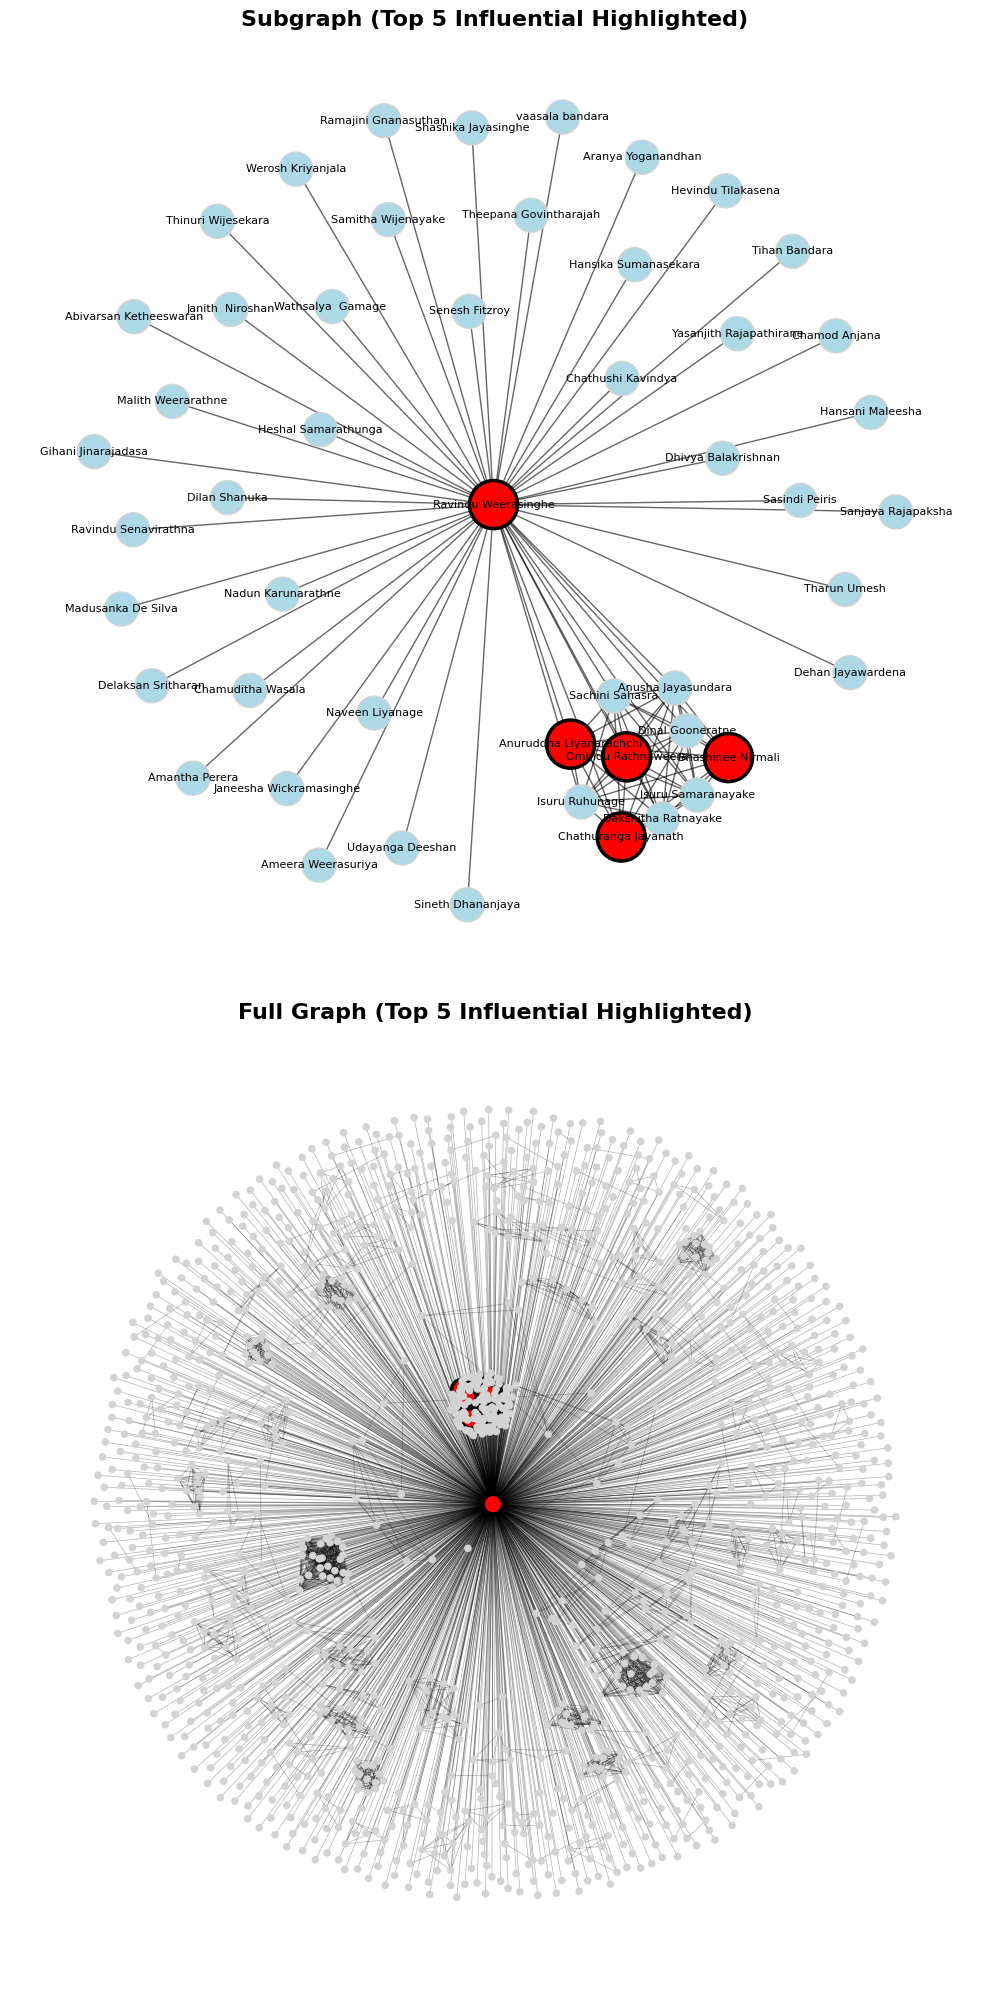

In [200]:
TOP_K = 5
top_k = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:TOP_K]

top_k_nodes = [n for n, _ in top_k]

print(f"Top {TOP_K} Influential Nodes (Eigenvector):")
for i, (n, v) in enumerate(top_k, 1):
    print(f"{i}. {n}: {v:.6f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))

# Subgraph
# =========
sample_size = 50
np.random.seed(45)
sampled_nodes = np.random.choice(list(G.nodes()), size=min(sample_size, G.number_of_nodes()), replace=False)
sampled_nodes = list(sampled_nodes)

# Add MY_NODE and top k nodes
if MY_NODE not in sampled_nodes:
    sampled_nodes[0] = MY_NODE
for node in top_k_nodes:
    if node not in sampled_nodes:
        sampled_nodes[np.random.randint(len(sampled_nodes))] = node

G_sample = G.subgraph(sampled_nodes)
pos_sample = nx.spring_layout(G_sample, seed=42)
node_colors = ['red' if node in top_k_nodes else 'lightblue' for node in G_sample.nodes()]
node_sizes = [1200 if node in top_k_nodes else 600 for node in G_sample.nodes()]
edge_colors = ['black' if node in top_k_nodes else 'lightgray' for node in G_sample.nodes()]
line_widths = [2.5 if node in top_k_nodes else 1 for node in G_sample.nodes()]

ax1.set_title(f"Subgraph (Top {TOP_K} Influential Highlighted)", fontsize=16, fontweight='bold')
nx.draw_networkx_nodes(G_sample, pos_sample, node_color=node_colors, node_size=node_sizes,
                       edgecolors=edge_colors, linewidths=line_widths, ax=ax1)
nx.draw_networkx_labels(G_sample, pos_sample, font_size=8, ax=ax1)
nx.draw_networkx_edges(G_sample, pos_sample, arrows=False, width=1, alpha=0.6, ax=ax1)
ax1.axis('off')

# Full graph
# ==========
pos_full = nx.spring_layout(G, seed=42)
node_colors_full = ['red' if node in top_k_nodes else 'lightgray' for node in G.nodes()]
node_sizes_full = [200 if node in top_k_nodes else 20 for node in G.nodes()]
edge_colors_full = ['black' if node in top_k_nodes else 'lightgray' for node in G.nodes()]
line_widths_full = [2.5 if node in top_k_nodes else 1 for node in G.nodes()]

ax2.set_title(f"Full Graph (Top {TOP_K} Influential Highlighted)", fontsize=16, fontweight='bold')
nx.draw_networkx_nodes(G, pos_full, node_color=node_colors_full, node_size=node_sizes_full,
                       edgecolors=edge_colors_full, linewidths=line_widths_full, ax=ax2)
nx.draw_networkx_edges(G, pos_full, arrows=False, width=0.5, alpha=0.3, ax=ax2)
ax2.axis('off')

plt.tight_layout()
plt.show()

### Community Detection - Louvain Method

Number of communities detected: 17

Community sizes:
Community 0: 11 nodes
Community 1: 1107 nodes
Community 2: 132 nodes
Community 3: 12 nodes
Community 4: 27 nodes
Community 5: 10 nodes
Community 6: 13 nodes
Community 7: 8 nodes
Community 8: 14 nodes
Community 9: 7 nodes
Community 10: 9 nodes
Community 11: 13 nodes
Community 12: 12 nodes
Community 13: 8 nodes
Community 14: 14 nodes
Community 15: 20 nodes
Community 16: 10 nodes


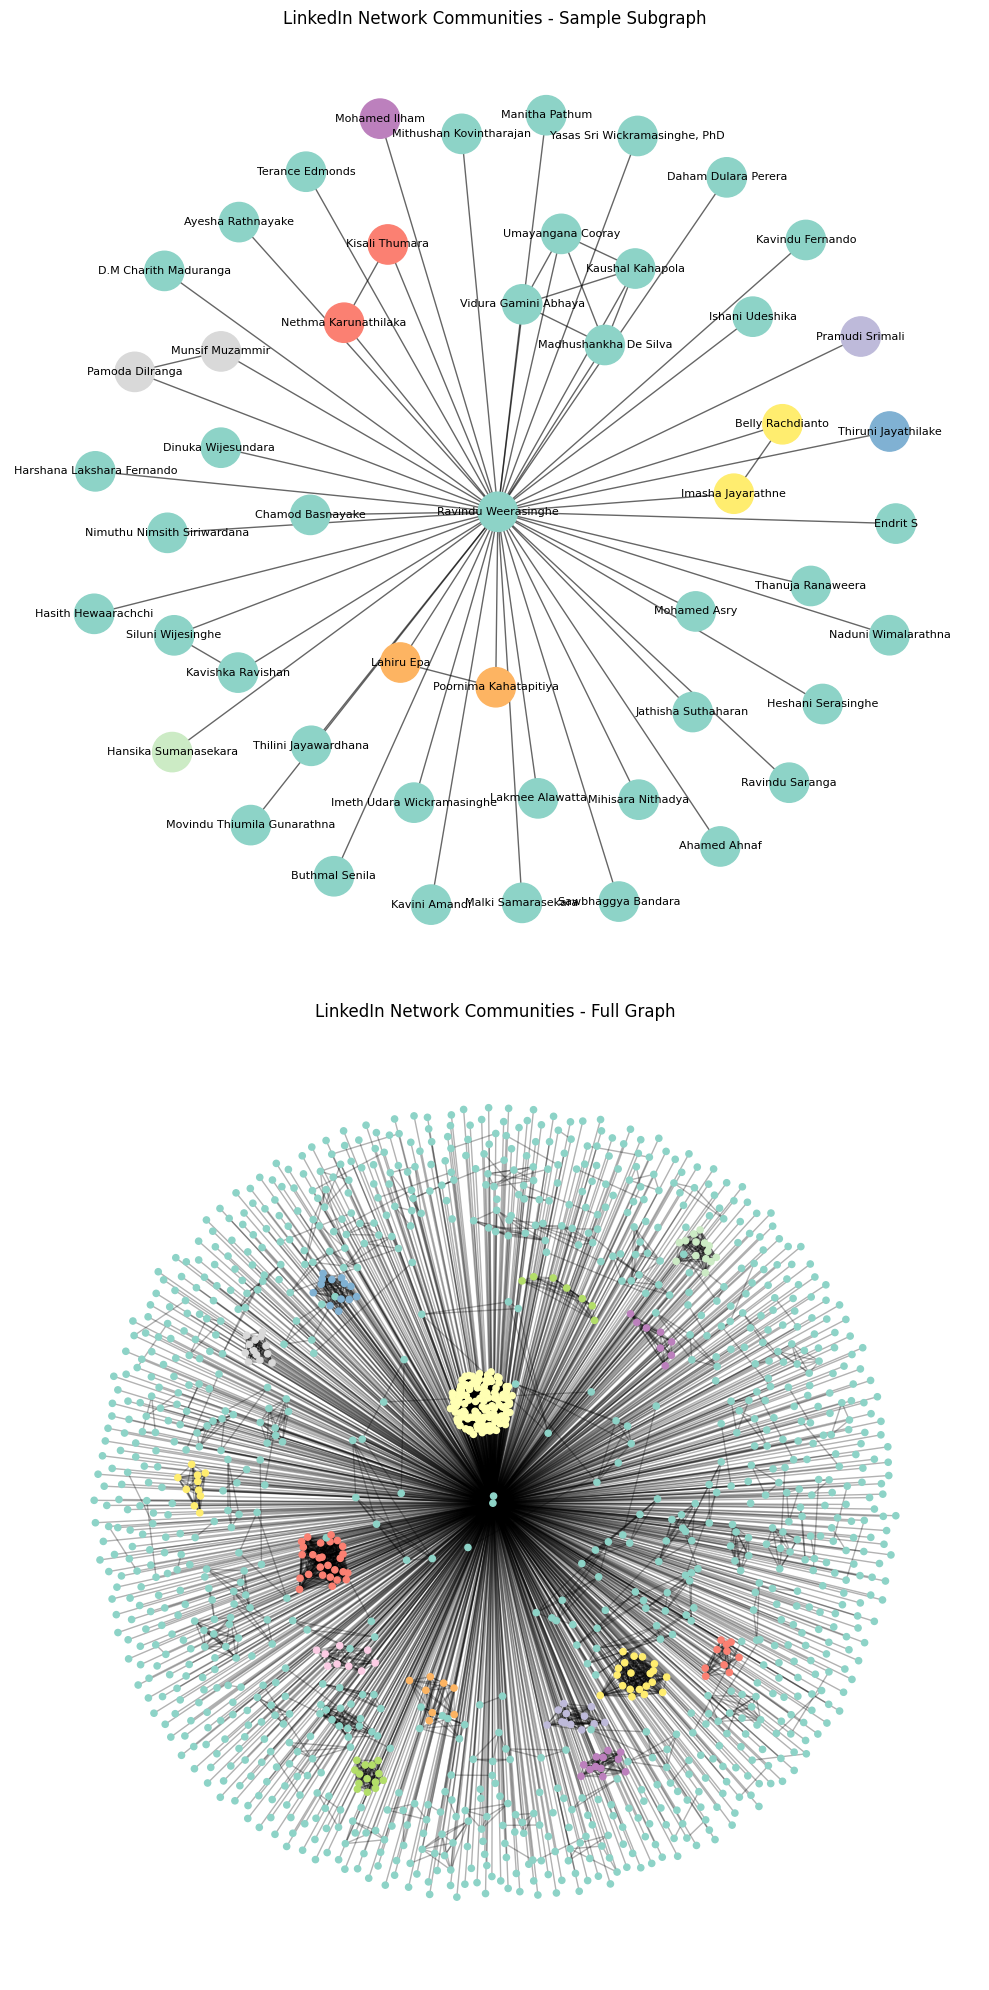

In [201]:
from community import community_louvain

communities = community_louvain.best_partition(G)

# Map all nodes to their communities
community_map = {}
for node, community_id in communities.items():
    if community_id not in community_map:
        community_map[community_id] = []
    community_map[community_id].append(node)

print(f"Number of communities detected: {len(community_map)}")
print("\nCommunity sizes:")
for community_id, nodes in sorted(community_map.items()):
    print(f"Community {community_id}: {len(nodes)} nodes")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))

# 1. Show subgraph
sample_size = 50
np.random.seed(100)  # for reproducibility
sampled_nodes = np.random.choice(list(G.nodes()), size=min(sample_size, G.number_of_nodes()), replace=False)
if MY_NODE not in sampled_nodes:
    sampled_nodes = list(sampled_nodes)
    sampled_nodes[0] = MY_NODE

G_sample = G.subgraph(sampled_nodes)
pos_sample = nx.spring_layout(G_sample, seed=42)

# Color nodes by community
colors = [communities.get(node, -1) for node in G_sample.nodes()]
ax1.set_title("LinkedIn Network Communities - Sample Subgraph")
nx.draw_networkx_nodes(G_sample, pos_sample, node_color=colors, node_size=800, cmap='Set3', ax=ax1)
nx.draw_networkx_labels(G_sample, pos_sample, font_size=8, ax=ax1)
nx.draw_networkx_edges(G_sample, pos_sample, arrows=False, width=1, alpha=0.6, ax=ax1)
ax1.axis('off')

# 2. Full graph
pos_full = nx.spring_layout(G, seed=42)
colors_full = [communities.get(node, -1) for node in G.nodes()]

ax2.set_title("LinkedIn Network Communities - Full Graph")
nx.draw_networkx_nodes(G, pos_full, node_color=colors_full, node_size=20, cmap='Set3', ax=ax2)
nx.draw_networkx_edges(G, pos_full, arrows=False, width=1, alpha=0.3, ax=ax2)
ax2.axis('off')

plt.tight_layout()
plt.show()

### Top influential node removed

Top 1 Most Influential Node to Remove:
  Ravindu Weerasinghe: 0.093696


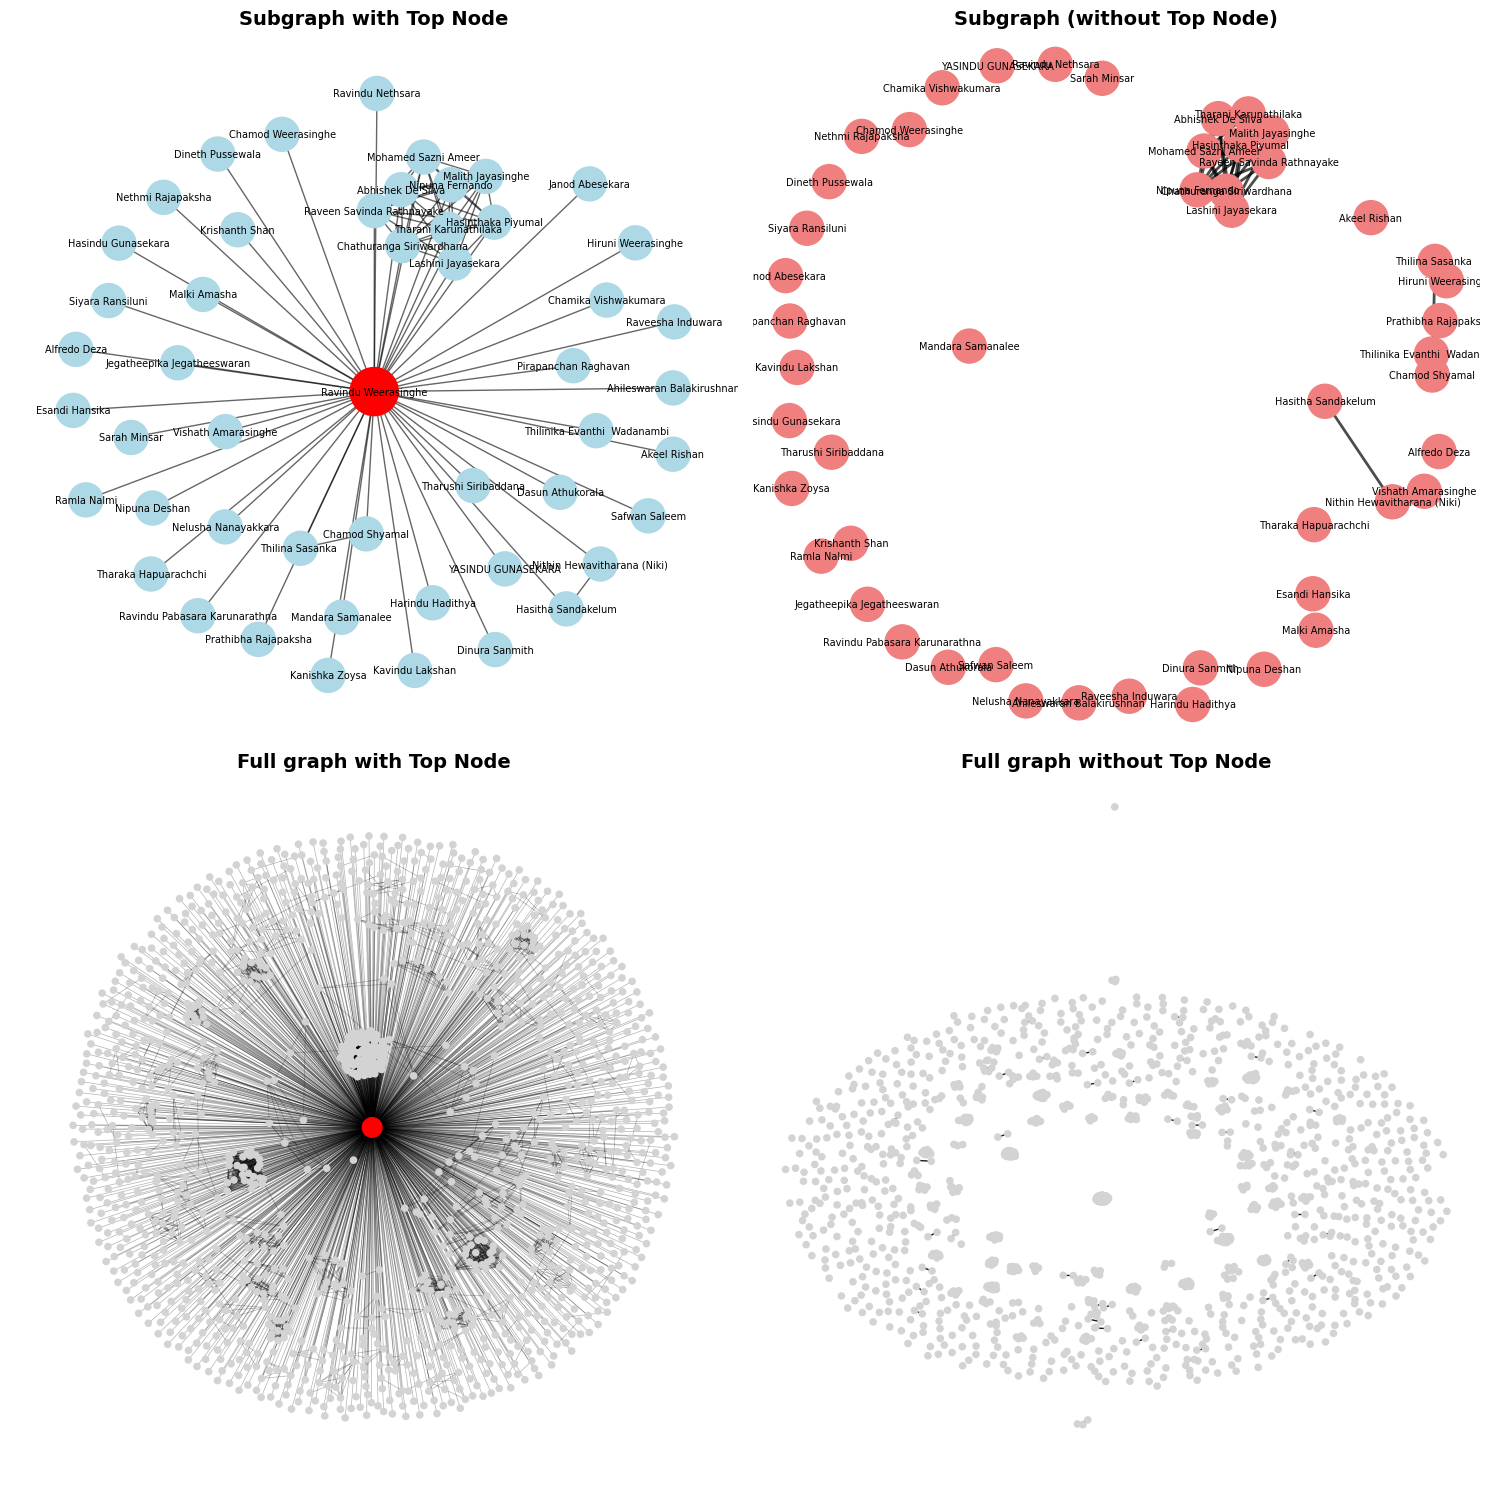

In [202]:
top_1 = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[0]
top_1_node = top_1[0]

print("Top 1 Most Influential Node to Remove:")
print(f"  {top_1_node}: {top_1[1]:.6f}")

G_without_top1 = G.copy()
G_without_top1.remove_node(top_1_node)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# ===== ORIGINAL NETWORK - SUBGRAPH =====
sample_size = 50
np.random.seed(42)
sampled_nodes = np.random.choice(list(G.nodes()), size=min(sample_size, G.number_of_nodes()), replace=False)
sampled_nodes = list(sampled_nodes)

if MY_NODE not in sampled_nodes:
    sampled_nodes[0] = MY_NODE
if top_1_node not in sampled_nodes:
    sampled_nodes[np.random.randint(len(sampled_nodes))] = top_1_node

G_sample_orig = G.subgraph(sampled_nodes)
pos_orig = nx.spring_layout(G_sample_orig, seed=42)

node_colors_orig = ['red' if node == top_1_node else 'lightblue' for node in G_sample_orig.nodes()]
node_sizes_orig = [1200 if node == top_1_node else 600 for node in G_sample_orig.nodes()]

axes[0, 0].set_title("Subgraph with Top Node", fontsize=14, fontweight='bold')
nx.draw_networkx_nodes(G_sample_orig, pos_orig, node_color=node_colors_orig, 
                       node_size=node_sizes_orig, ax=axes[0, 0])
nx.draw_networkx_labels(G_sample_orig, pos_orig, font_size=7, ax=axes[0, 0])
nx.draw_networkx_edges(G_sample_orig, pos_orig, arrows=False, width=1, alpha=0.6, ax=axes[0, 0])
axes[0, 0].axis('off')

# ===== NETWORK WITHOUT TOP 1 - SUBGRAPH =====
sampled_nodes_without = [n for n in sampled_nodes if n != top_1_node]
G_sample_without = G_without_top1.subgraph(sampled_nodes_without)
pos_without = nx.spring_layout(G_sample_without, seed=42, k=0.5, iterations=50)

node_colors_without = ['lightcoral' for node in G_sample_without.nodes()]
node_sizes_without = [600 for node in G_sample_without.nodes()]

axes[0, 1].set_title("Subgraph (without Top Node)", fontsize=14, fontweight='bold')
nx.draw_networkx_nodes(G_sample_without, pos_without, node_color=node_colors_without, 
                       node_size=node_sizes_without, ax=axes[0, 1])
nx.draw_networkx_labels(G_sample_without, pos_without, font_size=7, ax=axes[0, 1])
nx.draw_networkx_edges(G_sample_without, pos_without, arrows=False, width=2, alpha=0.7, ax=axes[0, 1])
axes[0, 1].axis('off')

# ===== ORIGINAL NETWORK - FULL GRAPH =====
pos_full_orig = nx.spring_layout(G, seed=42)
node_colors_full_orig = ['red' if node == top_1_node else 'lightgray' for node in G.nodes()]
node_sizes_full_orig = [200 if node == top_1_node else 20 for node in G.nodes()]

axes[1, 0].set_title("Full graph with Top Node", fontsize=14, fontweight='bold')
nx.draw_networkx_nodes(G, pos_full_orig, node_color=node_colors_full_orig, 
                       node_size=node_sizes_full_orig, ax=axes[1, 0])
nx.draw_networkx_edges(G, pos_full_orig, arrows=False, width=0.5, alpha=0.3, ax=axes[1, 0])
axes[1, 0].axis('off')

# ===== NETWORK WITHOUT TOP 1 - FULL GRAPH =====
pos_full_without = nx.spring_layout(G_without_top1, seed=42, k=0.5, iterations=50)
node_colors_full_without = ['lightgray' for node in G_without_top1.nodes()]
node_sizes_full_without = [20 for node in G_without_top1.nodes()]

axes[1, 1].set_title("Full graph without Top Node", fontsize=14, fontweight='bold')
nx.draw_networkx_nodes(G_without_top1, pos_full_without, node_color=node_colors_full_without, 
                       node_size=node_sizes_full_without, ax=axes[1, 1])
nx.draw_networkx_edges(G_without_top1, pos_full_without, arrows=False, width=1, alpha=0.9, ax=axes[1, 1])
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()